# Assignment3
## Autoencoder
### Determinstic autoencoder

In [2]:
# libraries
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
# local imports
import MNIST_dataloader
import autoencoder_template # AE
import autoencoder_ex4 # AE4
import os
import torch.nn.functional as F
# local imports
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.io import output_notebook
import numpy as np
import matplotlib.cm
import torch.optim as optim

output_notebook()

Loading BokehJS ...

## Load data MNST

In [3]:
# set torches random seed
torch.random.manual_seed(0)
PATH = os.getcwd()
data_loc = os.path.join(PATH,'data')

# EX1
## Batch and load data

In [4]:
# bactch design

batch_size = 64

learning_rate = 3e-4
train_loader, test_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)
len(train_loader)

938

## Train model

In [5]:

batch_size = 64

learning_rate = 3e-4
no_epochs = 5
# device fridenly not at all
if  torch.cuda.is_available():
        device = torch.device('cuda')
else:
    device = torch.device('cpu')
# enumerate(tqdm(train_loader))
# initialize model
AE = autoencoder_template.AE()
AE.to(device) 

optimizer = torch.optim.Adam(AE.parameters(), lr=learning_rate)

train_los = []
for epoch in range(no_epochs):
    print(f"\nTraining Epoch {epoch}:")
    # go over all minibatches
    # len(x_clean) = batch_idx*batch_size
    loss_sum =0 # reset loss
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
        # fill in how to train your network using only the clean images
        
        optimizer.zero_grad() # 将模型的参数梯度初始化为0
        # x_clean = x_clean.to(device) # Transfer to GPU
        output,feature = AE(x_clean)
        loss_ = nn.MSELoss()
        loss_(output,x_clean)
        # nn.MSELoss(output,x_clean,label)
        # loss = F.mse_loss(output, x_clean)
        # print(loss)
        loss_(output,x_clean).backward()
        # optimizer
        optimizer.step()
        loss_sum += loss_(output,x_clean).item()
    train_los.append(loss_sum/len(test_loader.dataset.Clean_Images)) # normlaize
    torch.save(AE.state_dict(), os.path.join(data_loc, 'epoch-{}.pt'.format(epoch)))

# # save the trained model
# model.state_dict()

# torch.save(AE.state_dict(), data_loc) # '/Model/state.pt'



Training Epoch 0:


100%|██████████| 938/938 [00:25<00:00, 36.95it/s]



Training Epoch 1:


100%|██████████| 938/938 [00:25<00:00, 36.90it/s]



Training Epoch 2:


100%|██████████| 938/938 [00:25<00:00, 37.36it/s]



Training Epoch 3:


100%|██████████| 938/938 [00:24<00:00, 37.61it/s]



Training Epoch 4:


100%|██████████| 938/938 [00:24<00:00, 38.82it/s]


## Plot train loss plot

In [6]:
# # plot train loss
from plot_hw import plot_trans
p = plot_trans(train_los)
show(p,notebook_handle=True)

# Load model

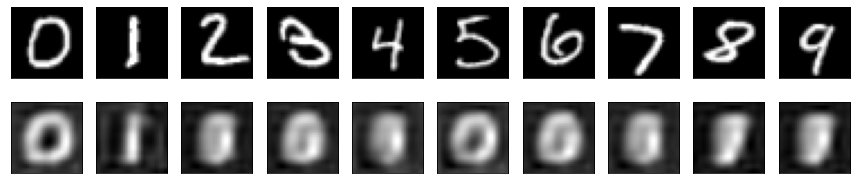

In [4]:
AE = autoencoder_template.AE()


x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]
# load the trained model
AE.load_state_dict(torch.load(data_loc+'/epoch-4.pt'))
AE.eval()
AE = AE.cpu()
x_output_example,x_feature_example = AE(x_clean_example)
# show the examples in a plot
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
        
    plt.subplot(2,10,i+11)
    plt.imshow(x_output_example[i,0,:,:].detach().numpy(),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()


# EX2
## a
Create a Python script that visualizes the latent space that is provided by the Encoder for all the MNIST images in the test set. \newline
 - determine the output of the Encoder \newline
 - make a scatter plot where you use the $[2 \times 1]$ vector of the latent space as values for the horizontal and vertical axes in a 2D scatter plot.
 Give each datapoint in the scatter plot a color that corresponds to the digit that is written in the original image
### Combine digits to track as a tensor
Visualize the latent space


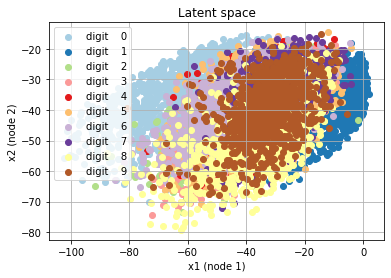

In [11]:
numbers = []
for x in range(10):
    index = (labels_test == x).nonzero().reshape(-1) # labels_test value == 1-10
    cache = torch.index_select(x_clean_test, 0, index) # Abstract only fit the index
    _,vectors = AE(cache)
    numbers.append(vectors)


# %%# Visulize the latent space
colors = matplotlib.cm.Paired(np.linspace(0, 1, len(numbers)))
fig, ax = plt.subplots()
ax.set_title('Latent space')
ax.set_xlabel('x1 (node 1)')
ax.set_ylabel('x2 (node 2)')
for (points, color, digit) in zip(numbers, colors, range(10)):
    ax.scatter([item[0][0][0] for item in points.detach().numpy()],
                [item[0][0][1] for item in points.detach().numpy()], color=color, label='digit    {}'.format(digit))
    ax.grid(True)
ax.legend()

# Ex3
## a
- Encode the `x_clean_test` and perform a 1-nearest neighbour search. And search the datapt from the training set that has the smallest Euclidean distance in the latent space.
- Assign the class to the test image that corresponds with the class `labels_train` of its nearest neighbour.


In [18]:
from sklearn.neighbors import NearestNeighbors

# Get train features
model = AE
_,train_feature = model(x_clean_test) # x_clean_test # x_clean_train
train_feature = train_feature.detach().numpy()
train_features = []
for features in train_feature:
    train_features.append(features[0][0])

# Closest Euclidean distance -> KNN
knn_gallery = NearestNeighbors(n_neighbors=1).fit(train_features)
test_features = []
for i, points in zip(range(10),numbers):
    items = []
    print('Length of number',i,'in test set is', len(points.detach().numpy()))
    for item in points.detach().numpy():
        items.append(item[0][0])
    test_features.append(items)
for i in range(10):
    predictions = knn_gallery.kneighbors(test_features[i], return_distance=False)
    prediction_tensor = torch.LongTensor(predictions).squeeze()
    # Get the predicted label
    label_pred = torch.index_select(labels_train, 0, prediction_tensor)
    # Index of corectly labeled images
    index = (label_pred == i).nonzero().reshape(-1)
    accuracy = 100*len(index)/len(test_features[i])
    print('Accuracy of number',i,'is', accuracy,'%')

Length of number 0 in test set is 980
Length of number 1 in test set is 1135
Length of number 2 in test set is 1032
Length of number 3 in test set is 1010
Length of number 4 in test set is 982
Length of number 5 in test set is 892
Length of number 6 in test set is 958
Length of number 7 in test set is 1028
Length of number 8 in test set is 974
Length of number 9 in test set is 1009
Accuracy of number 0 is 10.918367346938776 %
Accuracy of number 1 is 12.070484581497798 %
Accuracy of number 2 is 8.236434108527131 %
Accuracy of number 3 is 10.0 %
Accuracy of number 4 is 10.488798370672098 %
Accuracy of number 5 is 8.856502242152466 %
Accuracy of number 6 is 9.08141962421712 %
Accuracy of number 7 is 12.062256809338521 %
Accuracy of number 8 is 9.958932238193018 %
Accuracy of number 9 is 8.721506442021804 %


# Ex4 
Modification and convert the network into a classficiation oriented purposed.

## a

- Replace the last Convolutional layer( with actviation and pooling layer) with a Fully-connected *Dense layer*. Use a Flatten and activation layer as well if needed. 
- Assign a proper loss fucntion and train and test network on the same training and test data.
you replace the last layer, but now you have 10 classes. Thus you need a linear layer that inputs 16x2x2=64 and outputs 1x10.
[Can use nn.Flatten() to go from 16x2x2 to 1x64]
### train model

In [14]:
import autoencoder_ex4
batch_size = 64
learning_rate = 3e-4
no_epochs = 2
train_los = []
# device fridenly not at all
if  torch.cuda.is_available():
        device = torch.device('cuda')
else:
    device = torch.device('cpu')

# enumerate(tqdm(train_loader))
# initialize model




In [ ]:
import sys
model_4 = autoencoder_ex4.Encoder()
loss_4 = torch.nn.CrossEntropyLoss()
optimizer_4 = torch.optim.Adam(model_4.parameters(),lr=learning_rate)
device = "cuda" if torch.cuda.is_available() else "cpu"
#using clean image to train x_clean_train
loss_iter = []
loss_epoch = []
loss_iter_test = []
loss_epoch_test = []
torch.random.manual_seed(0)
model_4 = model_4.to(device=device)
no_epochs = 2

for epoch in range(no_epochs):
    print(f"Training on {device}. Epoch {epoch+1}:")
    # go over all minibatches
    sys.stdout.flush()
    total_loss=0
    model_4.train()
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
        # fill in how to train your network using only the clean images
        optimizer_4.zero_grad()
        inputs = x_clean.to(device=device)
        outputs= model_4(inputs)
        loss = loss_4(outputs,label)
        loss.backward()
        optimizer_4.step()
        loss_iter.append(loss.data)
        total_loss += loss.data
    loss_epoch.append(total_loss/len(train_loader))
    print(f'epoch[{epoch+1}/{no_epochs}],Cross Entropy Loss(Train):{total_loss/len(train_loader)}')
    sys.stdout.flush()
    sys.stdout.flush()
    total_loss = 0
    model_4.eval()
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(test_loader)):
        inputs = x_clean.to(device=device)
        outputs= model_4(inputs)
        loss_test = loss_4(outputs,label)
        loss_iter_test.append(loss_test.data)
        total_loss += loss_test.data
    loss_epoch_test.append(total_loss/len(test_loader))
    print(f'epoch[{epoch+1}/{no_epochs}],Cross Entropy Loss(Test):{total_loss/len(test_loader)}')
    
    sys.stdout.flush()
# torch.save(model_4,os.path.join(model_loc,'exercise4.ptg'))

In [15]:
loss_ = torch.nn.CrossEntropyLoss()
AE4 = autoencoder_ex4.Encoder()
AE4.to(device) 
los_iter = []
optimizer = torch.optim.Adam(AE4.parameters(), lr=learning_rate)

for epoch in range(no_epochs):
    print(f"\nTraining Epoch {epoch}:")
    # go over all minibatches
    # len(x_clean) = batch_idx*batch_size
    # sys.stdout.flush()
    loss_sum =0 # reset loss
    AE4.train()
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
        # fill in how to train your network using only the clean images       
        optimizer.zero_grad() # 将模型的参数梯度初始化为0
        # x_clean = x_clean.to(device) # Transfer to GPU
        inputs = x_clean.to(device=device)
        output = AE4(inputs)
        loss_4 = loss_(output,label)
        # loss_ = nn.MSELoss()
        # loss_(output,label)
        # nn.MSELoss(output,x_clean,label)
        # loss = F.mse_loss(output, x_clean)
        # print(loss)
        loss_4.backward()
        # loss_(output,x_clean).backward()
        # optimizer
        optimizer.step()
        los_iter.append(loss_4.data)
        # loss_(output,x_clean).item()
        loss_sum += loss_4.item()
    train_los.append(loss_sum/len(test_loader.dataset.Clean_Images)) # normlaize
    # torch.save(AE4.state_dict(), os.path.join(data_loc, 'epoch-{}.pt'.format(epoch)))

# # save the trained model
# model.state_dict()

# torch.save(AE4.state_dict(), os.path.join(data_loc, 'epoch-{}.pt'.format(epoch)))
# torch.save(AE.state_dict(), data_loc) # '/Model/state.pt'


Training Epoch 0:


100%|██████████| 938/938 [00:33<00:00, 27.82it/s]



Training Epoch 1:


100%|██████████| 938/938 [00:35<00:00, 26.47it/s]


In [16]:
from plot_hw import plot_trans
p = plot_trans(train_los)
show(p,notebook_handle=True)